In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

In [4]:
# Read train and test datasets
pd.set_option('display.max_columns', 100)
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


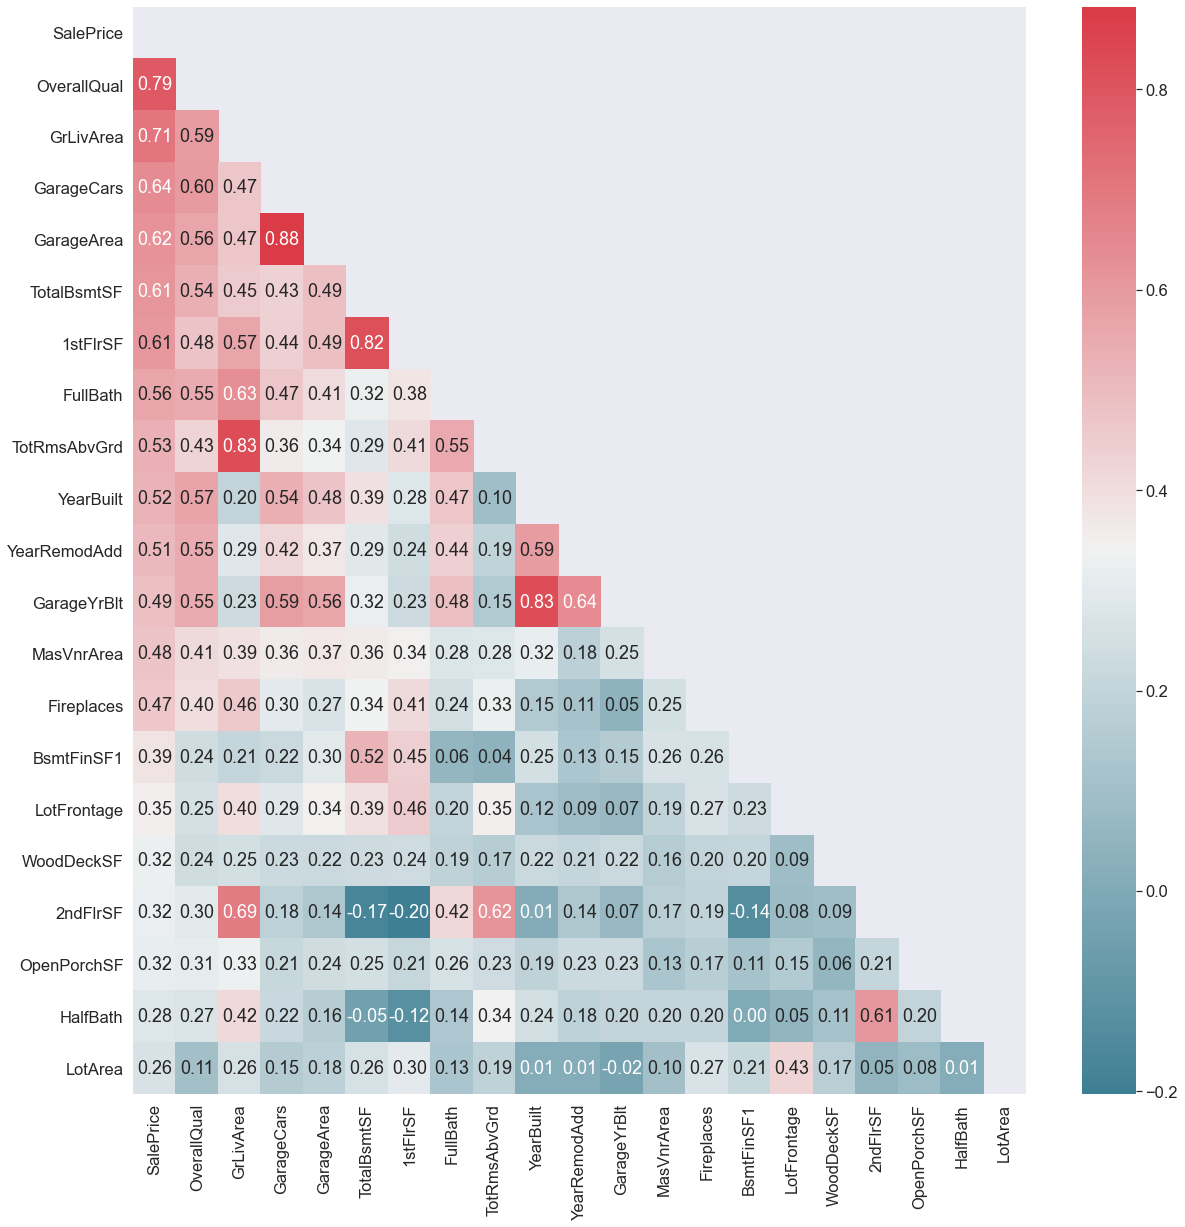

In [5]:
corr = train_df[train_df.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.26)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()
del corr, dropSelf, top_corr

In [6]:
# Split training set into target variable and explanatory variables
target = np.log(train_df["SalePrice"])
train_df = train_df.drop("SalePrice", axis=1)

train_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000,1460.000,1460,1201.000,1460.000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000,1460.000,1460.000,1460.000,1460,1460,1460,1460,1452,1452.000,1460,1460,1460,1423,1423,1422,1423,1460.000,1422,1460.000,1460.000,1460.000,1460,1460,1460,1459,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460,1460.000,1460,1460.000,770,1379,1379.000,1379,1460.000,1460.000,1379,1379,1460,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,7,281,54,1460.000,1460.000,1460.000,1460,1460
unique,nan,nan,5,nan,nan,2,2,4,4,2,5,3,25,9,8,5,8,nan,nan,nan,nan,6,8,15,16,4,nan,4,5,6,4,4,4,6,nan,6,nan,nan,nan,6,5,2,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan,7,nan,5,6,nan,3,nan,nan,5,5,3,nan,nan,nan,nan,nan,nan,3,4,4,nan,nan,nan,9,6
top,nan,nan,RL,nan,nan,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,Unf,nan,Unf,nan,nan,nan,GasA,Ex,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,Gd,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,Gd,MnPrv,Shed,nan,nan,nan,WD,Normal
freq,nan,nan,1151,nan,nan,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,nan,nan,nan,nan,1141,1434,515,504,864,nan,906,1282,647,649,1311,953,430,nan,1256,nan,nan,nan,1428,741,1365,1334,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,735,nan,1360,nan,380,870,nan,605,nan,nan,1311,1326,1340,nan,nan,nan,nan,nan,nan,3,157,49,nan,nan,nan,1267,1198
mean,730.500,56.897,NaN,70.050,10516.828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099,5.575,1971.268,1984.866,NaN,NaN,NaN,NaN,NaN,103.685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.640,NaN,46.549,567.240,1057.429,NaN,NaN,NaN,NaN,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,NaN,6.518,NaN,0.613,NaN,NaN,1978.506,NaN,1.767,472.980,NaN,NaN,NaN,94.245,46.660,21.954,3.410,15.061,2.759,NaN,NaN,NaN,43.489,6.322,2007.816,NaN,NaN
std,421.610,42.301,NaN,24.285,9981.265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.383,1.113,30.203,20.645,NaN,NaN,NaN,NaN,NaN,181.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098,NaN,161.319,441.867,438.705,NaN,NaN,NaN,NaN,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,NaN,1.625,NaN,0.645,NaN,NaN,24.690,NaN,0.747,213.805,NaN,NaN,NaN,125.339,66.256,61.119,29.317,55.757,40.177,NaN,NaN,NaN,496.123,2.704,1.328,NaN,NaN
min,1.000,20.000,NaN,21.000,1300.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1872.000,1950.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,2.000,NaN,0.000,NaN,NaN,1900.000,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN
25%,365.750,20.000,NaN,59.000,7553.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,1954.000,1967.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,223.000,795.750,NaN,NaN,NaN,NaN,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,NaN,5.000,NaN,0.000,NaN,NaN,1961.000,NaN,1.000,334.500,NaN,NaN,NaN,0.000,0.000,0.000,0

In [7]:
test_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1459.000,1459.000,1455,1232.000,1459.000,1459,107,1459,1459,1457,1459,1459,1459,1459,1459,1459,1459,1459.000,1459.000,1459.000,1459.000,1459,1459,1458,1458,1443,1444.000,1459,1459,1459,1415,1414,1415,1417,1458.000,1417,1458.000,1458.000,1458.000,1459,1459,1459,1459,1459.000,1459.000,1459.000,1459.000,1457.000,1457.000,1459.000,1459.000,1459.000,1459.000,1458,1459.000,1457,1459.000,729,1383,1381.000,1381,1458.000,1458.000,1381,1381,1459,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,3,290,51,1459.000,1459.000,1459.000,1458,1459
unique,nan,nan,5,nan,nan,2,2,4,4,1,5,3,25,9,5,5,7,nan,nan,nan,nan,6,4,13,15,4,nan,4,5,6,4,4,4,6,nan,6,nan,nan,nan,4,5,2,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan,7,nan,5,6,nan,3,nan,nan,4,5,3,nan,nan,nan,nan,nan,nan,2,4,3,nan,nan,nan,9,6
top,nan,nan,RL,nan,nan,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,GLQ,nan,Unf,nan,nan,nan,GasA,Ex,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,Gd,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,Ex,MnPrv,Shed,nan,nan,nan,WD,Normal
freq,nan,nan,1114,nan,nan,1453,70,934,1311,1457,1081,1396,218,1251,1444,1205,745,nan,nan,nan,nan,1169,1442,510,510,878,nan,892,1256,661,634,1295,951,431,nan,1237,nan,nan,nan,1446,752,1358,1337,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,757,nan,1357,nan,364,853,nan,625,nan,nan,1293,1328,1301,nan,nan,nan,nan,nan,nan,2,172,46,nan,nan,nan,1258,1204
mean,2190.000,57.378,NaN,68.580,9819.161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.079,5.554,1971.358,1983.663,NaN,NaN,NaN,NaN,NaN,100.709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.204,NaN,52.619,554.295,1046.118,NaN,NaN,NaN,NaN,1156.535,325.968,3.544,1486.046,0.434,0.065,1.571,0.378,2.854,1.042,NaN,6.385,NaN,0.581,NaN,NaN,1977.721,NaN,1.766,472.769,NaN,NaN,NaN,93.175,48.314,24.243,1.794,17.064,1.744,NaN,NaN,NaN,58.168,6.104,2007.770,NaN,NaN
std,421.321,42.747,NaN,22.377,4955.517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.437,1.114,30.390,21.130,NaN,NaN,NaN,NaN,NaN,177.626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.268,NaN,176.754,437.260,442.899,NaN,NaN,NaN,NaN,398.166,420.610,44.043,485.566,0.531,0.252,0.555,0.503,0.830,0.208,NaN,1.509,NaN,0.647,NaN,NaN,26.431,NaN,0.776,217.049,NaN,NaN,NaN,127.745,68.883,67.228,20.208,56.610,30.492,NaN,NaN,NaN,630.807,2.722,1.302,NaN,NaN
min,1461.000,20.000,NaN,21.000,1470.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1879.000,1950.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,407.000,0.000,0.000,407.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,3.000,NaN,0.000,NaN,NaN,1895.000,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN
25%,1825.500,20.000,NaN,58.000,7391.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,1953.000,1963.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,219.250,784.000,NaN,NaN,NaN,NaN,873.500,0.000,0.000,1117.500,0.000,0.000,1.000,0.000,2.000,1.000,NaN,5.000,NaN,0.000,NaN,NaN,1959.000,NaN,1.000,318.000,NaN,NaN,NaN,0.000,0.000,0.

In [8]:
# For numerical features, replace missing values with median, calculated from training set
for feature in ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
                "BsmtFullBath", "BsmtHalfBath", "GarageYrBlt", "GarageCars", "GarageArea"]:
    median = train_df[feature].median()
    train_df[feature] = np.where(train_df[feature].isna(), median, train_df[feature])
    test_df[feature] = np.where(test_df[feature].isna(), median, test_df[feature])

In [9]:
# Determine which columns are categorical features
categorical_columns = ["MSSubClass"] # This column is recorded as numeric, but actually represents the type of dwelling
for col in train_df:
    if train_df[col].dtype == "object":
        categorical_columns.append(col)

# For categorical features, replace missing values with "None/Unknown"
for col in categorical_columns:
    train_df[col] = np.where(train_df[col].isna(), "None/Unknown", train_df[col])
    test_df[col] = np.where(test_df[col].isna(), "None/Unknown", test_df[col])
    
train_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000,1460,1460,1460.000,1460.000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000,1460.000,1460.000,1460.000,1460,1460,1460,1460,1460,1460.000,1460,1460,1460,1460,1460,1460,1460,1460.000,1460,1460.000,1460.000,1460.000,1460,1460,1460,1460,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460,1460.000,1460,1460.000,1460,1460,1460.000,1460,1460.000,1460.000,1460,1460,1460,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460,1460,1460,1460.000,1460.000,1460.000,1460,1460
unique,nan,15,5,nan,nan,2,3,4,4,2,5,3,25,9,8,5,8,nan,nan,nan,nan,6,8,15,16,5,nan,4,5,6,5,5,5,7,nan,7,nan,nan,nan,6,5,2,6,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan,7,nan,6,7,nan,4,nan,nan,6,6,3,nan,nan,nan,nan,nan,nan,4,5,5,nan,nan,nan,9,6
top,nan,20,RL,nan,nan,Pave,None/Unknown,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,Unf,nan,Unf,nan,nan,nan,GasA,Ex,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,None/Unknown,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,None/Unknown,None/Unknown,None/Unknown,nan,nan,nan,WD,Normal
freq,nan,536,1151,nan,nan,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,nan,nan,nan,nan,1141,1434,515,504,864,nan,906,1282,647,649,1311,953,430,nan,1256,nan,nan,nan,1428,741,1365,1334,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,735,nan,1360,nan,690,870,nan,605,nan,nan,1311,1326,1340,nan,nan,nan,nan,nan,nan,1453,1179,1406,nan,nan,nan,1267,1198
mean,730.500,NaN,NaN,69.864,10516.828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099,5.575,1971.268,1984.866,NaN,NaN,NaN,NaN,NaN,103.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.640,NaN,46.549,567.240,1057.429,NaN,NaN,NaN,NaN,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,NaN,6.518,NaN,0.613,NaN,NaN,1978.589,NaN,1.767,472.980,NaN,NaN,NaN,94.245,46.660,21.954,3.410,15.061,2.759,NaN,NaN,NaN,43.489,6.322,2007.816,NaN,NaN
std,421.610,NaN,NaN,22.028,9981.265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.383,1.113,30.203,20.645,NaN,NaN,NaN,NaN,NaN,180.731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098,NaN,161.319,441.867,438.705,NaN,NaN,NaN,NaN,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,NaN,1.625,NaN,0.645,NaN,NaN,23.997,NaN,0.747,213.805,NaN,NaN,NaN,125.339,66.256,61.119,29.317,55.757,40.177,NaN,NaN,NaN,496.123,2.704,1.328,NaN,NaN
min,1.000,NaN,NaN,21.000,1300.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1872.000,1950.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,2.000,NaN,0.000,NaN,NaN,1900.000,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN
25%,365.750,NaN,NaN,60.000,7553.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,1954.000,1967.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,223.000,795.750,NaN,NaN,NaN,NaN,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,NaN,5.000,NaN,0.000,NaN,NaN,1962.000,NaN,1.0

In [10]:
test_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1459.000,1459,1459,1459.000,1459.000,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459.000,1459.000,1459.000,1459.000,1459,1459,1459,1459,1459,1459.000,1459,1459,1459,1459,1459,1459,1459,1459.000,1459,1459.000,1459.000,1459.000,1459,1459,1459,1459,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459,1459.000,1459,1459.000,1459,1459,1459.000,1459,1459.000,1459.000,1459,1459,1459,1459.000,1459.000,1459.000,1459.000,1459.000,1459.000,1459,1459,1459,1459.000,1459.000,1459.000,1459,1459
unique,nan,16,6,nan,nan,2,3,4,4,2,5,3,25,9,5,5,7,nan,nan,nan,nan,6,4,14,16,5,nan,4,5,6,5,5,5,7,nan,7,nan,nan,nan,4,5,2,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5,nan,8,nan,6,7,nan,4,nan,nan,5,6,3,nan,nan,nan,nan,nan,nan,3,5,4,nan,nan,nan,10,6
top,nan,20,RL,nan,nan,Pave,None/Unknown,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,GLQ,nan,Unf,nan,nan,nan,GasA,Ex,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,None/Unknown,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,None/Unknown,None/Unknown,None/Unknown,nan,nan,nan,WD,Normal
freq,nan,543,1114,nan,nan,1453,1352,934,1311,1457,1081,1396,218,1251,1444,1205,745,nan,nan,nan,nan,1169,1442,510,510,878,nan,892,1256,661,634,1295,951,431,nan,1237,nan,nan,nan,1446,752,1358,1337,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,757,nan,1357,nan,730,853,nan,625,nan,nan,1293,1328,1301,nan,nan,nan,nan,nan,nan,1456,1169,1408,nan,nan,nan,1258,1204
mean,2190.000,NaN,NaN,68.646,9819.161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.079,5.554,1971.358,1983.663,NaN,NaN,NaN,NaN,NaN,99.674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.166,NaN,52.583,554.242,1046.081,NaN,NaN,NaN,NaN,1156.535,325.968,3.544,1486.046,0.434,0.065,1.571,0.378,2.854,1.042,NaN,6.385,NaN,0.581,NaN,NaN,1977.843,NaN,1.766,472.774,NaN,NaN,NaN,93.175,48.314,24.243,1.794,17.064,1.744,NaN,NaN,NaN,58.168,6.104,2007.770,NaN,NaN
std,421.321,NaN,NaN,20.562,4955.517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.437,1.114,30.390,21.130,NaN,NaN,NaN,NaN,NaN,177.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.114,NaN,176.699,437.115,442.749,NaN,NaN,NaN,NaN,398.166,420.610,44.043,485.566,0.531,0.252,0.555,0.503,0.830,0.208,NaN,1.509,NaN,0.647,NaN,NaN,25.720,NaN,0.776,216.974,NaN,NaN,NaN,127.745,68.883,67.228,20.208,56.610,30.492,NaN,NaN,NaN,630.807,2.722,1.302,NaN,NaN
min,1461.000,NaN,NaN,21.000,1470.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,1879.000,1950.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,407.000,0.000,0.000,407.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,3.000,NaN,0.000,NaN,NaN,1895.000,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN
25%,1825.500,NaN,NaN,60.000,7391.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,5.000,1953.000,1963.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,219.500,784.000,NaN,NaN,NaN,NaN,873.500,0.000,0.000,1117.500,0.000,0.000,1.000,0.000,2.000,1.000,NaN,5.000,NaN,0.000,NaN,NaN,1960.500,NaN

In [11]:
# Encode categorical features using OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
encoder.fit(train_df[categorical_columns])

train_numeric = np.array(train_df.drop(categorical_columns, axis=1))
train_categorical = encoder.transform(train_df[categorical_columns])
train = np.concatenate((train_numeric, train_categorical), axis=1)
train = train[:, 1:] # drop Id column

test_numeric = np.array(test_df.drop(categorical_columns, axis=1))
test_categorical = encoder.transform(test_df[categorical_columns])
test = np.concatenate((test_numeric, test_categorical), axis=1)
test = test[:, 1:] # drop Id column

print(train)
print(test)

[[6.500e+01 8.450e+03 7.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [8.000e+01 9.600e+03 6.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [6.800e+01 1.125e+04 7.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 ...
 [6.600e+01 9.042e+03 7.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [6.800e+01 9.717e+03 5.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [7.500e+01 9.937e+03 5.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]
[[8.0000e+01 1.1622e+04 5.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [8.1000e+01 1.4267e+04 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [7.4000e+01 1.3830e+04 5.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [1.6000e+02 2.0000e+04 5.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.2000e+01 1.0441e+04 5.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [7.4000e+01 9.6270e+03 7.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]


In [12]:
from sklearn.linear_model import LassoCV

# Trying out Lasso from sklearn
lasso = LassoCV()
k_fold = KFold(n_splits=5)
error_rates = []

# K-fold cross-validation to estimate the RMSE on unseen data
for train_index, test_index in k_fold.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    error_rates.append(rmse)
    print(f"RMSE for this fold: {rmse}")

print(f"Average RMSE: {np.mean(error_rates)}")

RMSE for this fold: 0.1609390094871926
RMSE for this fold: 0.20240754891860657
RMSE for this fold: 0.17682123259663124
RMSE for this fold: 0.18437955201998135
RMSE for this fold: 0.26690940266684254
Average RMSE: 0.1982913491378509


In [13]:
test_pred = np.exp(lasso.predict(test))
output = pd.concat([test_df["Id"], pd.DataFrame(test_pred, columns=["SalePrice"])], axis=1)
output.to_csv("submission.csv", index=False)
output.head()

,Id,SalePrice
0,1461,137559.228
1,1462,156142.379
2,1463,192054.612
3,1464,187755.276
4,1465,165629.338
